In [ ]:
%pip install statsmodels scikit-learn optuna prettytable matplotlib

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
import pandas as pd
import numpy as np

In [31]:
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

In [32]:
df=pd.read_csv('../data/final_data.csv')
df.head()

,Inflation,Month,Year,pmi,PartNo,Description,Quantity,Sales Price,Total Sales,Swaraj Engines Stock Price,M&M Stock Price,Escorts Kuboto Stock Price
0,7.59,1,2020,250,0503BA0290N-RK,ALFA HUB,85,2118.60,59367,1125.0,532.9,630.0
1,7.59,1,2020,250,0503BA0290N,Front Wheel Hub,318,3536.35,59367,1125.0,532.9,630.0
2,7.59,1,2020,250,0502BA1050N,Alfa Rear Wheel Hub LH,209,1383.36,59367,1125.0,532.9,630.0
3,7.59,1,2020,250,0502BA1060N,Alfa Rear Wheel Hub RH,119,4849.50,59367,1125.0,532.9,630.0
4,7.59,1,2020,250,0602AAB00260N,Brake Drum ALFA,134,2462.26,59367,1125.0,532.9,630.0


In [33]:
# Convert 'Month' and 'Year' into a datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df.sort_values(by=['PartNo', 'Date'])  # Ensure sorting

# Drop redundant columns
df = df.drop(columns=['Month', 'Year', 'Description'])

# Display the processed dataframe structure
df.head()

,Inflation,pmi,PartNo,Quantity,Sales Price,Total Sales,Swaraj Engines Stock Price,M&M Stock Price,Escorts Kuboto Stock Price,Date
120,7.59,250,(SE01B00G00037),245,381.13,59367,1125.0,532.90,630.00,2020-01-01
291,6.58,243,(SE01B00G00037),277,362.92,64937,1230.0,566.00,798.95,2020-02-01
462,5.84,222,(SE01B00G00037),347,343.63,35216,1230.5,453.55,820.00,2020-03-01
633,7.22,27,(SE01B00G00037),261,291.78,12456,890.0,281.00,637.00,2020-04-01
804,6.26,54,(SE01B00G00037),318,288.83,64860,1000.0,366.65,713.35,2020-05-01


In [34]:
# Dictionary to store RMSE values for each part
rmse_scores = {}

In [35]:
# Unique part numbers
part_numbers = df['PartNo'].unique()

In [36]:
# Iterate over each part
for part in part_numbers:
    part_data = df[df['PartNo'] == part].set_index('Date')
    
    # Define dependent and independent variables
    y = part_data['Quantity']
    X = part_data.drop(columns=['Quantity', 'PartNo'])
    
    # Train-test split (80-20 split)
    split_idx = int(len(y) * 0.8)
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    
    # Fit ARIMAX model
    model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    
    # Predict on the test set
    y_pred = results.get_forecast(steps=len(y_test), exog=X_test).predicted_mean
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[part] = rmse

/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/usman/miniconda3/envs/curie/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

In [37]:
import matplotlib.pyplot as plt

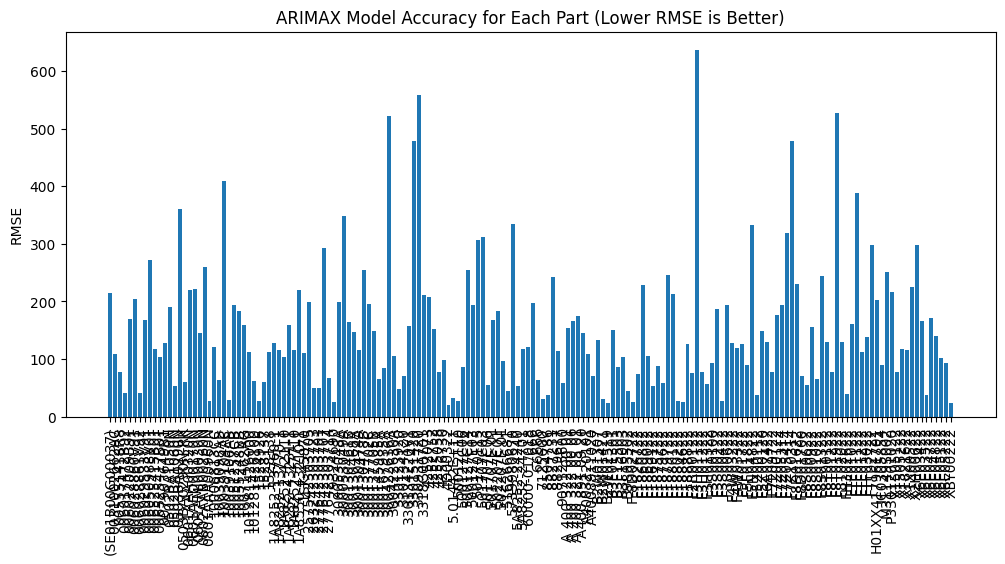

In [38]:
# Plot RMSE values for each part
plt.figure(figsize=(12, 5))
plt.bar(rmse_scores.keys(), rmse_scores.values())
plt.xticks(rotation=90)
plt.ylabel("RMSE")
plt.title("ARIMAX Model Accuracy for Each Part (Lower RMSE is Better)")
plt.show()

In [39]:
rmse_scores

{'(SE01B00G00037)': np.float64(214.50238905971327),
 '0031002662AC': np.float64(107.98545542005931),
 '005551418R8': np.float64(77.45211300791243),
 '006017472B92': np.float64(40.843265543116935),
 '006022009B91': np.float64(169.06896569927704),
 '006028860V91': np.float64(204.33807638658612),
 '006028861V92': np.float64(40.32195067730405),
 '006029533V91': np.float64(168.63632132140026),
 '006050988V01': np.float64(271.7953650174653),
 '006525415B01': np.float64(116.68060918920567),
 '006525417B01': np.float64(103.61760073335714),
 '007903649B1': np.float64(127.07487983679843),
 '0502BA1050N': np.float64(189.65771957523282),
 '0502BA1060N': np.float64(54.06561567287875),
 '0503BA0290N': np.float64(360.0199886602773),
 '0503BA0290N-RK': np.float64(60.19087160308246),
 '0601AAA00320N': np.float64(219.11141644690863),
 '0601AED00170N': np.float64(221.94177310099155),
 '0601AMJ00030N': np.float64(145.71073576902344),
 '0602AAB00260N': np.float64(260.501004719918),
 '0801AAA00960N': np.flo